In [ ]:
!pip install botorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from botorch.test_functions import Hartmann
import numpy as np
import torch
import random

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
# create an instance of negated 6d Hartmann function in a maximization setting
neg_hartmann6 = Hartmann(dim=6, negate=True)

In [ ]:
neg_hartmann6.optimal_value

3.32237

In [ ]:
# create 10x6 random numbers from a uniform distribution
train_x = torch.rand(10, 6)
# obtain the corresponding functional evaluation as a column vector
train_obj = neg_hartmann6(train_x).unsqueeze(-1)

In [ ]:
train_x.shape

torch.Size([10, 6])

In [ ]:
train_obj

tensor([[0.1066],
        [0.0032],
        [0.0027],
        [0.7279],
        [0.0881],
        [0.8750],
        [0.0038],
        [0.1098],
        [0.0103],
        [0.7158]])

In [ ]:
from botorch.models import SingleTaskGP
# create a single-task exact GP model instance
# use a GP prior with Matern kernel and constant mean function by default
model = SingleTaskGP(train_X=train_x, train_Y=train_obj)

In [ ]:
# check original hyperparameters
list(model.named_hyperparameters())

[('likelihood.noise_covar.raw_noise', Parameter containing:
  tensor([2.0000], requires_grad=True)),
 ('mean_module.raw_constant', Parameter containing:
  tensor(0., requires_grad=True)),
 ('covar_module.raw_outputscale', Parameter containing:
  tensor(0., requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
  tensor([[0., 0., 0., 0., 0., 0.]], requires_grad=True))]

In [ ]:
from gpytorch.mlls import ExactMarginalLogLikelihood
# calculate the exact marginal log likelihood (MLL), i.e., negative loss
# for an exact Gaussian process with a Gaussian likelihood
mll = ExactMarginalLogLikelihood(model.likelihood, model)

In [ ]:
from botorch.fit import fit_gpytorch_model
# fit hyperparameters (kernel parameters and noise variance) of a GPyTorch model 
fit_gpytorch_model(mll);

In [ ]:
list(model.named_hyperparameters())

[('likelihood.noise_covar.raw_noise', Parameter containing:
  tensor([0.0060], requires_grad=True)),
 ('mean_module.raw_constant', Parameter containing:
  tensor(0.2433, requires_grad=True)),
 ('covar_module.raw_outputscale', Parameter containing:
  tensor(-2.1142, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
  tensor([[-0.7155, -0.7190, -0.7218, -0.8089, -1.1630, -0.5477]],
         requires_grad=True))]

In [ ]:
best_value = train_obj.max()
best_value

tensor(0.8750)

# Analytic EI

In [ ]:
from botorch.acquisition import ExpectedImprovement
EI = ExpectedImprovement(model=model, best_f=best_value)

In [ ]:
EI(train_x[0].view(1,-1))

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/lazy_tensor.py:1811: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


tensor([2.8202e-24], grad_fn=<MulBackward0>)

In [ ]:
# forward() method of ExpectedImprovement
from torch import Tensor
from torch.distributions import Normal

def forward(self, X: Tensor) -> Tensor:
    # convert the data type of best observed value best_f to that of candidate X
    self.best_f = self.best_f.to(X)
    # obtain the posterior instance at candidate location(s) X
    posterior = self.model.posterior(
        X=X, posterior_transform=self.posterior_transform
    )
    # get posterior mean
    mean = posterior.mean
    # deal with batch evaluation and broadcasting
    view_shape = mean.shape[:-2] if mean.shape[-2] == 1 else mean.shape[:-1]
    mean = mean.view(view_shape)
    # get posterior standard deviation, floored to avoid deviding by zero
    sigma = posterior.variance.clamp_min(1e-9).sqrt().view(view_shape)
    # calculate the standardized unit improvement, with best_f broadcasted if needed
    u = (mean - self.best_f.expand_as(mean)) / sigma
    # switch sign in the case of minimization
    if not self.maximize:
        u = -u
    # calculate ei based on analytic form
    normal = Normal(torch.zeros_like(u), torch.ones_like(u))
    ucdf = normal.cdf(u)
    updf = torch.exp(normal.log_prob(u))
    ei = sigma * (updf + u * ucdf)
    return ei


In [ ]:
from botorch.optim import optimize_acqf

new_point_analytic, _ = optimize_acqf(
    acq_function=EI, # acquisition function to guide the search
    bounds=torch.tensor([[0.0] * 6, [1.0] * 6]), # 6d unit hypercube
    q=1, # generate one candidate location in each iteration
    num_restarts=20, # number of starting points for multistart optimization
    raw_samples=100, # number of samples for initialization
    options={}, # additional options if any
)

In [ ]:
new_point_analytic

tensor([[0.1715, 0.3180, 0.0816, 0.4204, 0.1985, 0.7727]])

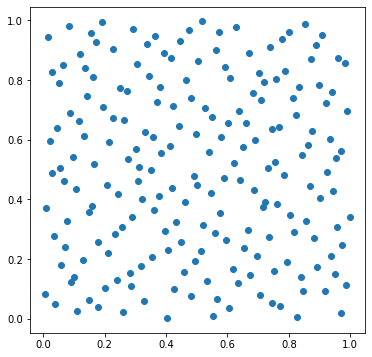

In [ ]:
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
plt.figure(figsize=(6,6))

sobol_engine = SobolEngine(dimension=2, scramble=True, seed=SEED)
sobol_samples = sobol_engine.draw(200)
xs_sobol = [x[0] for x in sobol_samples]
ys_sobol = [x[1] for x in sobol_samples]
plt.scatter(xs_sobol, ys_sobol)


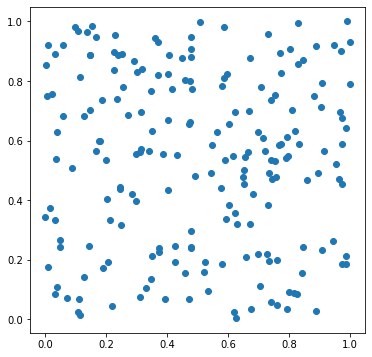

In [ ]:
plt.figure(figsize=(6,6))
random_samples = torch.rand(200, 2)
xs_uniform = [x[0] for x in random_samples]
ys_uniform = [x[1] for x in random_samples]
plt.scatter(xs_uniform, ys_uniform)

In [ ]:
from botorch.optim.optimize import gen_batch_initial_conditions

Xinit = gen_batch_initial_conditions(acq_function=EI, 
                                     bounds=torch.tensor([[0.0] * 6, [1.0] * 6]),
                                     q=1, 
                                     num_restarts=20, 
                                     raw_samples=100)

In [ ]:
Xinit.shape

torch.Size([20, 1, 6])

In [ ]:
def _gen_initial_conditions() -> Tensor:
    ic_gen = (
        gen_one_shot_kg_initial_conditions
        if isinstance(acq_function, qKnowledgeGradient)
        else gen_batch_initial_conditions
    )
    batch_initial_conditions = ic_gen(
        acq_function=acq_function,
        bounds=bounds,
        q=q,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        fixed_features=fixed_features,
        options=options,
        inequality_constraints=inequality_constraints,
        equality_constraints=equality_constraints,
    )
    return batch_initial_conditions

# if not initial_conditions_provided:
#     batch_initial_conditions = _gen_initial_conditions()

In [ ]:
from botorch.generation.gen import gen_candidates_scipy

batch_candidates, batch_acq_values = gen_candidates_scipy(
                initial_conditions=Xinit,
                acquisition_function=EI,
                lower_bounds=torch.tensor([[0.0] * 6]),
                upper_bounds=torch.tensor([[1.0] * 6]),
            )
# extract the index of the best candidate
best = torch.argmax(batch_acq_values.view(-1), dim=0)
batch_candidates = batch_candidates[best]
batch_candidates

tensor([[0.1715, 0.3180, 0.0816, 0.4204, 0.1985, 0.7727]])

# MC EI

In [ ]:
# SobolQMCNormalSampler
from botorch.sampling import SobolQMCNormalSampler
sampler = SobolQMCNormalSampler(1024, seed=1234)
posterior = model.posterior(train_x[0][None, :])
samples = sampler(posterior)

In [ ]:
samples

tensor([[[0.0506]],

        [[0.1386]],

        [[0.1737]],

        ...,

        [[0.1739]],

        [[0.1384]],

        [[0.0509]]], grad_fn=<UnsqueezeBackward0>)

In [ ]:
samples.shape

torch.Size([1024, 1, 1])

In [ ]:
# qExpectedImprovement
from botorch.acquisition import qExpectedImprovement
qEI = qExpectedImprovement(model, best_value, sampler)
qEI(train_x[0][None, :])

tensor([0.], grad_fn=<MeanBackward1>)

In [ ]:
qEI(batch_candidates[None, :])

tensor([0.0538], grad_fn=<MeanBackward1>)

In [ ]:
EI(batch_candidates[None, :])

tensor([0.0538], grad_fn=<MulBackward0>)

In [ ]:
def forward(self, X: Tensor) -> Tensor:
    posterior = self.model.posterior(
        X=X, posterior_transform=self.posterior_transform
    )
    samples = self.sampler(posterior)
    obj = self.objective(samples, X=X)
    obj = (obj - self.best_f.unsqueeze(-1).to(obj)).clamp_min(0)
    q_ei = obj.max(dim=-1)[0].mean(dim=0)
    return q_ei

In [ ]:
sampler = SobolQMCNormalSampler(num_samples=500, seed=0, resample=False)  # 500x100x1      
MC_EI = qExpectedImprovement(
    model, best_f=best_value, sampler=sampler
)
torch.manual_seed(seed=0) # to keep the restart conditions the same
new_point_mc, _ = optimize_acqf(
    acq_function=MC_EI,
    bounds=torch.tensor([[0.0] * 6, [1.0] * 6]),
    q=1,
    num_restarts=20,
    raw_samples=100,
    options={},
)

In [ ]:
new_point_mc

tensor([[0.1715, 0.3181, 0.0816, 0.4204, 0.1985, 0.7726]])

In [ ]:
torch.norm(new_point_mc - new_point_analytic)

tensor(0.0001)